# Lev Kozlov B20-RO1
# l.kozlov@innopolis.university

### Disclaimer: I might use some code from lab assignments as well as very common snippets of code from internet, like naming pipelines of sklearn as pipeline :)

In [477]:
!pip3 install pandas numpy matplotlib seaborn sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [478]:
# load dataset from a1_dataset.csv
df_raw = pd.read_csv('a1_dataset.csv')

## Encoding categorical values

In [479]:
# encode var3 using ordinary encoder using sklearn
from sklearn.preprocessing import OrdinalEncoder
df_raw['var3'] = OrdinalEncoder().fit_transform(df_raw[['var3']])

In [480]:
# encode var6 using ordinary encoder using sklearn
df_raw['var6'] = OrdinalEncoder().fit_transform(df_raw[['var6']])

In [481]:
df_raw.head()

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,137.0,138.0,393.00,0.0,2019-07-20 13:21:37
1,0,446.06,666.182,57.0,81.0,352.05,1.0,2019-04-04 21:30:46
2,1,235.50,398.097,101.0,90.0,339.00,0.0,2019-03-03 02:59:37
3,0,306.02,518.163,216.0,102.0,439.25,1.0,2019-03-19 08:00:58
4,0,453.08,600.156,36.0,105.0,422.95,0.0,2019-03-18 13:22:35


In [482]:
# try to use one hot encdoing for var3
from sklearn.preprocessing import OneHotEncoder

encoded = OneHotEncoder().fit_transform(df_raw[["var3"]]).toarray()

# add encoded to pandas dataframe
df_encoded = pd.DataFrame(
    encoded, columns=[f"var3_{i}" for i in range(encoded.shape[1])]
).join(df_raw)

# join encoded dataframe with original dataframe
df_encoded.head()

# I see no point in using this approach, because there are 
# no correlations inside var3 which we would be able to show


,var3_0,var3_1,var3_2,var3_3,var3_4,var3_5,var3_6,var3_7,var3_8,var3_9,...,var3_234,var3_235,target,var1,var2,var3,var4,var5,var6,var7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,509.18,417.681,137.0,138.0,393.00,0.0,2019-07-20 13:21:37
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,446.06,666.182,57.0,81.0,352.05,1.0,2019-04-04 21:30:46
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,235.50,398.097,101.0,90.0,339.00,0.0,2019-03-03 02:59:37
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,306.02,518.163,216.0,102.0,439.25,1.0,2019-03-19 08:00:58
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,453.08,600.156,36.0,105.0,422.95,0.0,2019-03-18 13:22:35


In [483]:
# get how many elements do we have now
df_raw.count()

target    925
var1      925
var2      925
var3      925
var4      325
var5      925
var6      925
var7      925
dtype: int64

In [484]:
# processing var7

# transform var7 into time series
df_raw["var7"] = pd.to_datetime(df_raw["var7"], errors="coerce")

# remove NaT rows which cannot be processed
df_raw = df_raw.dropna(subset=["var7"])

# I decided to extract this information from time series
df_raw.loc[:, "year"] = df_raw.loc[:, "var7"].dt.year
df_raw.loc[:, "month"] = df_raw.loc[:, "var7"].dt.month
df_raw.loc[:, "dayofmonth"] = df_raw.loc[:, "var7"].dt.day
df_raw.loc[:, "dayofweek"] = df_raw.loc[:, "var7"].dt.dayofweek

# get unique elements for each column
df_raw.nunique()


target          2
var1          893
var2          920
var3          235
var4           41
var5          831
var6            2
var7          920
year            1
month           7
dayofmonth     31
dayofweek       7
dtype: int64

In [485]:
# we see that year has only one unique value, so we can drop it
df_raw = df_raw.drop(columns=["year"])

# drop var7 because we already processed it into others
df_raw = df_raw.drop(columns=["var7"])

df_raw.head()

,target,var1,var2,var3,var4,var5,var6,month,dayofmonth,dayofweek
0,0,509.18,417.681,137.0,138.0,393.00,0.0,7,20,5
1,0,446.06,666.182,57.0,81.0,352.05,1.0,4,4,3
2,1,235.50,398.097,101.0,90.0,339.00,0.0,3,3,6
3,0,306.02,518.163,216.0,102.0,439.25,1.0,3,19,1
4,0,453.08,600.156,36.0,105.0,422.95,0.0,3,18,0


# Data imputation

In [486]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [487]:
# split data on what we have to train and what we have to fill
df_train = df_raw[df_raw["var4"].notnull()]
df_fill = df_raw[df_raw["var4"].isnull()]

/home/leo/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/home/leo/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='degree'>

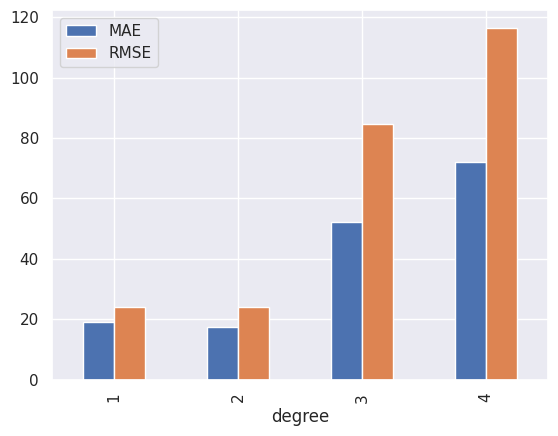

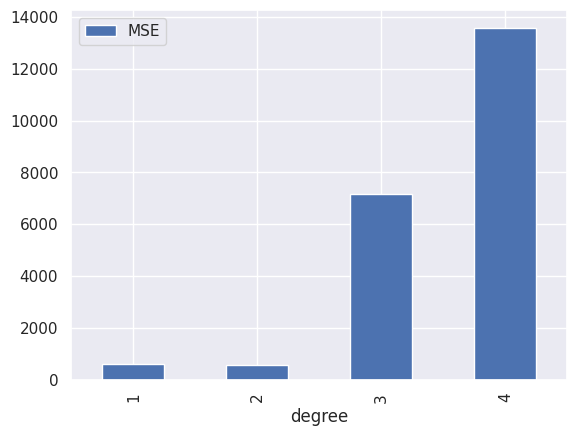

In [488]:
# try several polynomial degrees to find which one is the best

from sklearn import metrics


degrees = [1, 2, 3, 4]
result = pd.DataFrame(columns=["degree", "MAE", "MSE", "RMSE"])

X_train = df_train.drop(columns=["var4"])
Y_train = df_train["var4"]

# split data on several parts
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.3, random_state=1
)


for degree in degrees:
    # create pipeline
    pipeline = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=degree)),
            ("linear", LinearRegression()),
        ]
    )

    # fit pipeline
    pipeline = pipeline.fit(X_train, Y_train)
    Y_predicted = pipeline.predict(X_test)

    # calculate metrics
    mae = metrics.mean_absolute_error(Y_test, Y_predicted)
    mse = metrics.mean_squared_error(Y_test, Y_predicted)
    rmse = np.sqrt(metrics.mean_squared_error(Y_test, Y_predicted))

    # save result
    result = pd.concat(
        [
            result,
            pd.DataFrame(
                {
                    "degree": [degree],
                    "MAE": [mae],
                    "MSE": [mse],
                    "RMSE": [rmse],
                },
                columns=["degree", "MAE", "MSE", "RMSE"],
            ),
        ],
    )

# plot results
result.plot(x="degree", y=["MAE", "RMSE",], kind="bar")
result.plot(x="degree", y=["MSE"], kind="bar")

#### Selection of regression model

As plots show, degree = $2$ is the best choice.

In [489]:
# fill missing values for var4 using polynomial regression with degree=2

# create pipeline
pipeline = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression()),
    ]
)

# fit pipeline
pipeline = pipeline.fit(X_train, Y_train)

# predict missing values
Y_predicted = pipeline.predict(df_fill.drop(columns=["var4"]))
df_fill.loc[:, "var4"] = Y_predicted

# join filled dataframe with original dataframe
df_raw = pd.concat([df_train, df_fill])

df_raw.head()

/tmp/ipykernel_423173/1808328749.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fill.loc[:, "var4"] = Y_predicted


,target,var1,var2,var3,var4,var5,var6,month,dayofmonth,dayofweek
0,0,509.18,417.681,137.0,138.0,393.00,0.0,7,20,5
1,0,446.06,666.182,57.0,81.0,352.05,1.0,4,4,3
2,1,235.50,398.097,101.0,90.0,339.00,0.0,3,3,6
3,0,306.02,518.163,216.0,102.0,439.25,1.0,3,19,1
4,0,453.08,600.156,36.0,105.0,422.95,0.0,3,18,0


## PCA usage

In [490]:
# scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(df_raw.drop(columns=["target"]))
df_scaled = scaler.transform(df_raw.drop(columns=["target"]))

In [491]:
# implement PCA class

class PCA:
    """
    PCA class is basically a solution from scratch, which should work the same as sklearn.decomposition.PCA
    """
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit(self, X):
        # calculate covariance matrix
        cov_matrix = np.cov(X.T)
        
        # calculate eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        # sort eigenvalues and eigenvectors
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # get first n_components
        self.eigenvectors = eigenvectors[:, :self.n_components]

    def transform(self, X):
        # transform is basically just dot product on basis
        return X.dot(self.eigenvectors)

<AxesSubplot:>

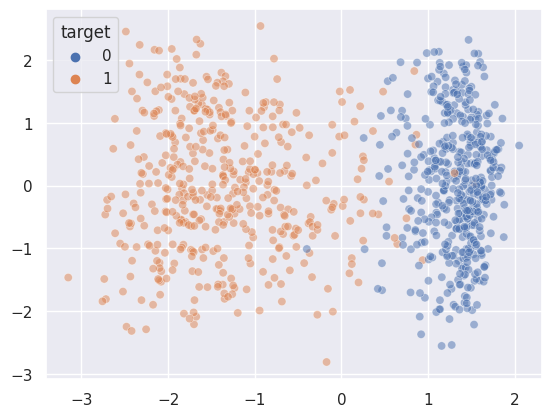

In [492]:
# create PCA model
pca = PCA(n_components=2)

pca.fit(df_scaled)

# transform data
df_pca = pca.transform(df_scaled)

# plot data using seaborn
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_raw["target"], alpha=0.5)


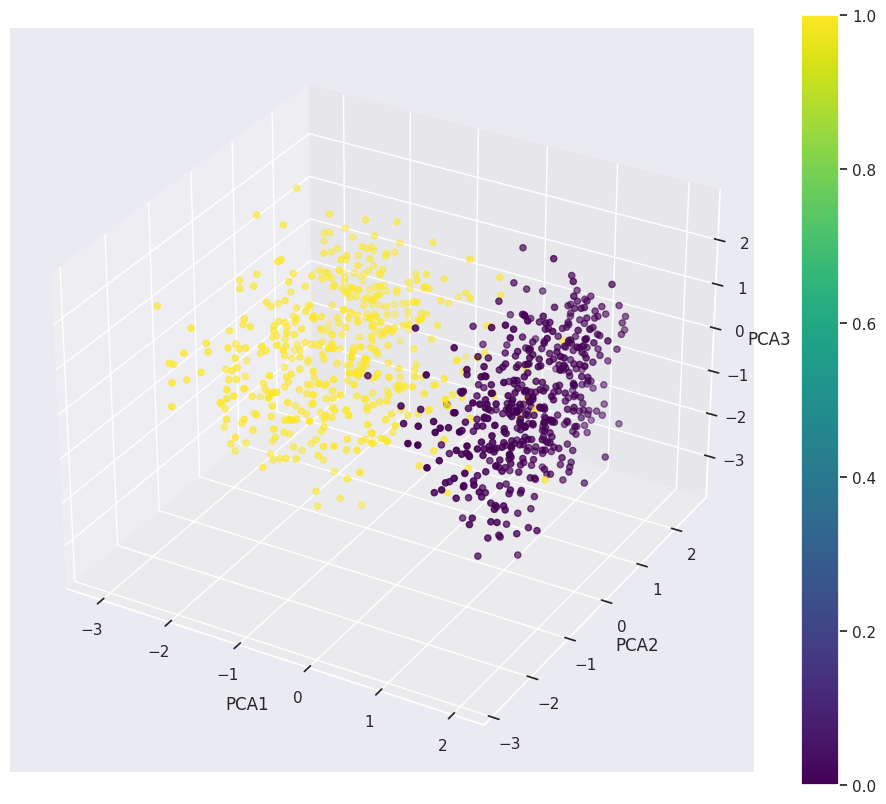

In [493]:
# test how PCA performs for 3 components
pca3 = PCA(n_components=3)

pca3.fit(df_scaled)

# transform data
df_pca3 = pca3.transform(df_scaled)

from mpl_toolkits.mplot3d import Axes3D

sns.set(style="darkgrid")


fig, axs = plt.subplots(1, 1, figsize=(12, 10), subplot_kw={"projection": "3d"})


axs.set_xlabel("PCA1")
axs.set_ylabel("PCA2")
axs.set_zlabel("PCA3")

axs.scatter(
    df_pca3[:, 0], df_pca3[:, 1], df_pca3[:, 2], c=df_raw["target"], cmap="viridis"
)


fig.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=axs)

# display a color bar with color map for data


There is no point in using PCA in 3 dimensions:
 - there are only 2 categories
 - data is spread well along one axis (PCA1) and (PCA3) will be just redundant

# Training

In [494]:
# create pandas dataframe to store results of tests, columns=(accuracy, accuracy_test, with_pca,method)
df_results = pd.DataFrame(columns=["accuracy", "accuracy_test", "with_pca", "method"])

# split data on train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    df_raw.drop(columns=["target"]), df_raw["target"], test_size=0.3, random_state=1
)


### Training without PCA

#### Logistic regression

In [495]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

logistic_regression = LogisticRegression(random_state=69)

# evaluate model using cross validation
scores = cross_val_score(
    logistic_regression, X_train, Y_train, cv=3, scoring="accuracy"
)

# evaluate performance on test set
logistic_regression.fit(X_train, Y_train)
Y_predicted = logistic_regression.predict(X_test)

# calculate accuracy, acc_pred
accuracy = np.mean(scores)
acc_pred = metrics.accuracy_score(Y_test, Y_predicted)

# save results
df_results = pd.concat([
    df_results,
    pd.DataFrame({
        "accuracy": [accuracy],
        "accuracy_test": [acc_pred],
        "with_pca": [False],
        "method": ["logistic_regression"]
    })
])

/home/leo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/leo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

#### KNN

In [496]:
# evaluate model on KNN

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# hyperparameter tuning for n_neighbors between [1, 10]
parameters = {
    "n_neighbors": range(1, 10),
}
# create grid search
grid_search = GridSearchCV(knn, parameters, cv=3, scoring="accuracy")

# fit grid search
grid_search.fit(X_train, Y_train)

# get best parameters
best_parameters = grid_search.best_params_

knn = KNeighborsClassifier(n_neighbors=best_parameters["n_neighbors"])

# evaluate model using cross validation
scores = cross_val_score(knn, X_train, Y_train, cv=3, scoring="accuracy")

# evaluate performance on test set
knn.fit(X_train, Y_train)

Y_predicted = knn.predict(X_test)

# calculate accuracy, acc_pred
accuracy = np.mean(scores)
acc_pred = metrics.accuracy_score(Y_test, Y_predicted)

# save results
df_results = pd.concat(
    [
        df_results,
        pd.DataFrame(
            {
                "accuracy": [accuracy],
                "accuracy_test": [acc_pred],
                "with_pca": [False],
                "method": ["knn"],
            }
        ),
    ]
)


#### Naive Bayes

In [497]:
# evaluate model on Naive Bayes

from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

# evaluate model using cross validation
scores = cross_val_score(naive_bayes, X_train, Y_train, cv=3, scoring="accuracy")

# evaluate performance on test set
naive_bayes.fit(X_train, Y_train)

Y_predicted = naive_bayes.predict(X_test)

# calculate accuracy, acc_pred
accuracy = np.mean(scores)
acc_pred = metrics.accuracy_score(Y_test, Y_predicted)

# save results
df_results = pd.concat(
    [
        df_results,
        pd.DataFrame(
            {
                "accuracy": [accuracy],
                "accuracy_test": [acc_pred],
                "with_pca": [False],
                "method": ["naive_bayes"],
            }
        ),
    ]
)


### Training with PCA

In [498]:
X_pca = df_pca
Y_pca = df_raw["target"]

# split X, Y on train and test
Xpca_train, Xpca_test, Ypca_train, Ypca_test = train_test_split(
    X_pca, Y_pca, test_size=0.3, random_state=1
)


#### Logistic regression

In [499]:
# evaluate model on logistic regression

logistic_regression = LogisticRegression(random_state=69)

# evaluate model using cross validation
scores = cross_val_score(
    logistic_regression, Xpca_train, Ypca_train, cv=3, scoring="accuracy"
)

# evaluate performance on test set
logistic_regression.fit(Xpca_train, Ypca_train)

Ypca_predicted = logistic_regression.predict(Xpca_test)

# calculate accuracy, acc_pred
accuracy = np.mean(scores)
acc_pred = metrics.accuracy_score(Ypca_test, Ypca_predicted)

# save results
df_results = pd.concat([
    df_results,
    pd.DataFrame({
        "accuracy": [accuracy],
        "accuracy_test": [acc_pred],
        "with_pca": [True],
        "method": ["logistic_regression"]
    })
])

#### KNN

In [500]:
# evaluate model on KNN

knn = KNeighborsClassifier()

# hyperparameter tuning for n_neighbors between [1, 10]
parameters = {
    "n_neighbors": range(1, 10),
}

# create grid search
grid_search = GridSearchCV(knn, parameters, cv=3, scoring="accuracy")

# fit grid search
grid_search.fit(Xpca_train, Ypca_train)

# get best parameters
best_parameters = grid_search.best_params_

knn = KNeighborsClassifier(n_neighbors=best_parameters["n_neighbors"])

# evaluate model using cross validation
scores = cross_val_score(knn, Xpca_train, Ypca_train, cv=3, scoring="accuracy")

# evaluate performance on test set
knn.fit(Xpca_train, Ypca_train)

Ypca_predicted = knn.predict(Xpca_test)

# calculate accuracy, acc_pred
accuracy = np.mean(scores)
acc_pred = metrics.accuracy_score(Ypca_test, Ypca_predicted)

# save results
df_results = pd.concat(
    [
        df_results,
        pd.DataFrame(
            {
                "accuracy": [accuracy],
                "accuracy_test": [acc_pred],
                "with_pca": [True],
                "method": ["knn"],
            }
        ),
    ]
)

best_parameters


{'n_neighbors': 7}

#### Naive Bayes

In [501]:
# evaluate model on naive bayes

naive_bayes = GaussianNB()

# evaluate model using cross validation
scores = cross_val_score(
    naive_bayes, Xpca_train, Ypca_train, cv=3, scoring="accuracy"
)

# evaluate performance on test set
naive_bayes.fit(Xpca_train, Ypca_train)

Ypca_predicted = naive_bayes.predict(Xpca_test)

# calculate accuracy, acc_pred
accuracy = np.mean(scores)
acc_pred = metrics.accuracy_score(Ypca_test, Ypca_predicted)

# save results
df_results = pd.concat([
    df_results,
    pd.DataFrame({
        "accuracy": [accuracy],
        "accuracy_test": [acc_pred],
        "with_pca": [True],
        "method": ["naive_bayes"]
    })
])

### Results analysis

In [502]:
df_results

,accuracy,accuracy_test,with_pca,method
0,0.956553,0.967391,False,logistic_regression
0,0.965848,0.971014,False,knn
0,0.972079,0.978261,False,naive_bayes
0,0.979830,0.985507,True,logistic_regression
0,0.976730,0.985507,True,knn
0,0.973629,0.978261,True,naive_bayes


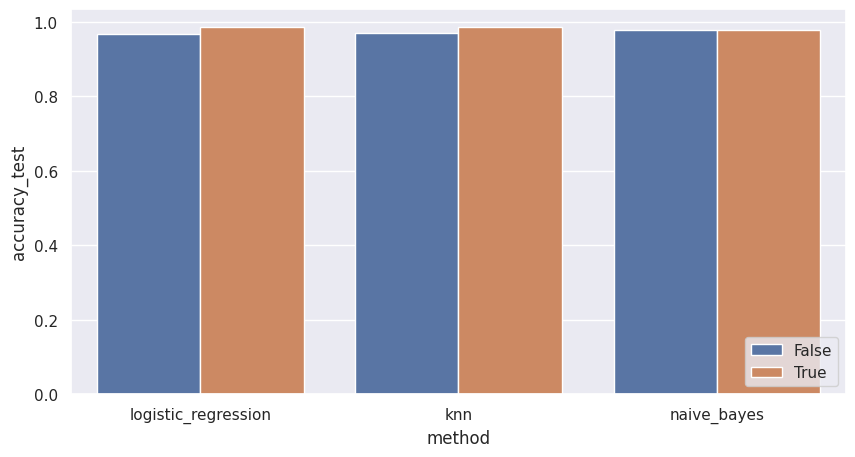

In [503]:
# plot how pca affects accuracy

# set plot size
plt.figure(figsize=(10, 5))
sns.barplot(x="method", y="accuracy_test", hue="with_pca", data=df_results)
plt.legend(loc='lower right')

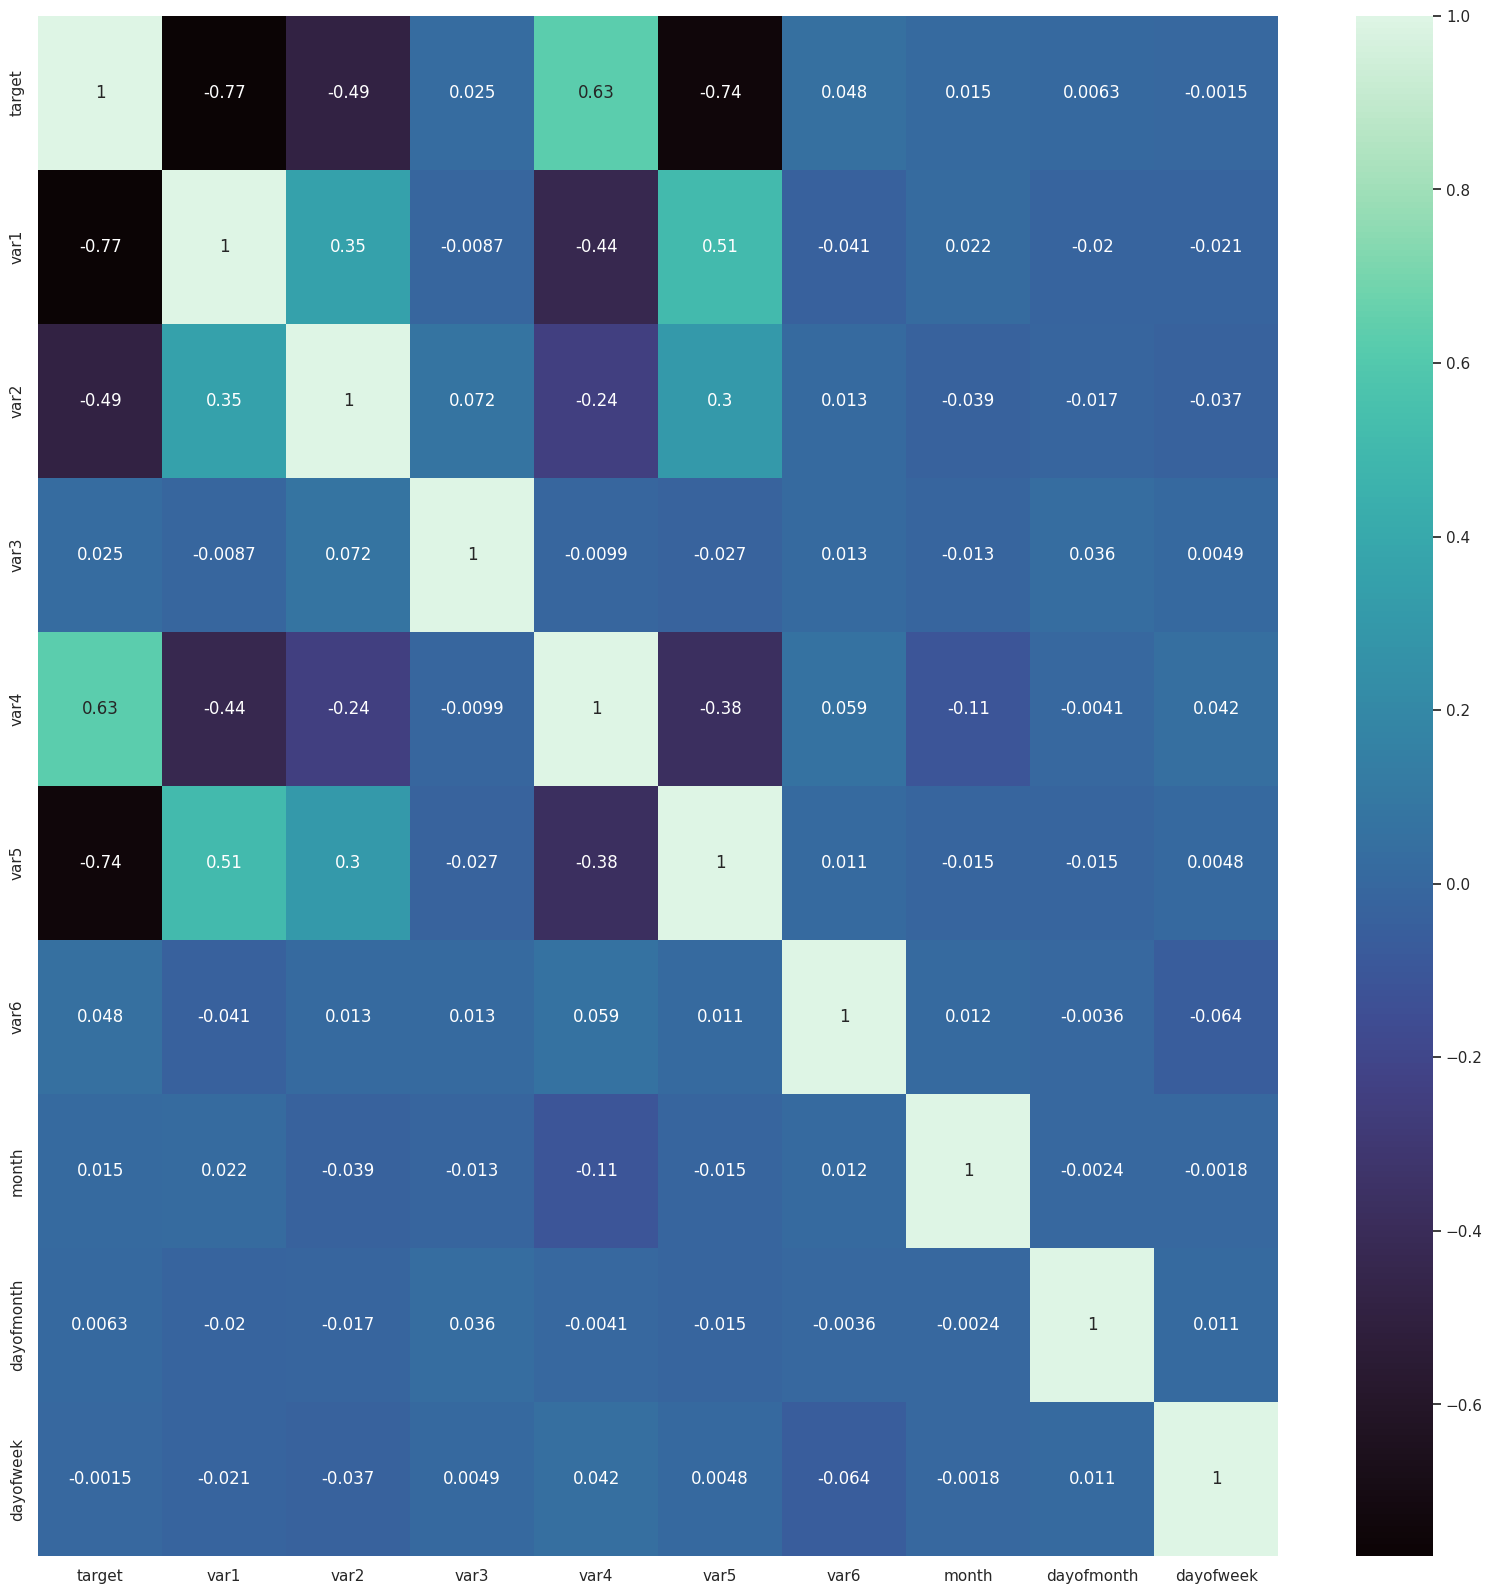

In [504]:
# find spearsman correlation

plt.figure(figsize=(20, 20))
ax = sns.heatmap(df_raw.corr(method="spearman"), annot=True, cmap="mako")

# save figure
plt.savefig("training-spearman.png")